<a href="https://colab.research.google.com/github/florian-frey/AudioSimilarity/blob/main/src/DimesionalityReductionSpec/AE_Training_ASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classifier based on 3-seconds-Spectrograms of the FMA Dataset

# 0 Concept explanation

## 0.1 Introduction:

This notebook will take the spectrogram images as an input and train a autoencoders. The goal of this is to reduce the number of dimensions from the original image (respectivly the original audio data), in order to ensure latent querys it in a vector database, whereas keeping most of the information of the original data.

The notebook uses three second rgb-melspectrogram of the FMA-small dataset.

## 0.2 Sources:
- https://www.tensorflow.org/tutorials/generative/cvae
- https://keras.io/examples/generative/vae/

# 1 Setup

## 1.1 Imports

In [ ]:
# update tensorflow to latest version
!pip uninstall -q -y tensorflow
!pip install -q tensorflow==2.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
# check tensorflow version
import tensorflow as tf
tf.__version__

'2.13.0'

In [ ]:
# install necessary librarys
!pip install tensorflow-probability

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ju3fk_a4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ju3fk_a4
  Resolved https://github.com/tensorflow/docs to commit 3b8eeeeddb85f606812874d2aa45823227afc6bf
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.7.13.64986-py3-none-any.whl size=183666 sha256=a83aaf241112528f17ec73894c6369fc2afa25eefaeaf159263796a8e77e45e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-_5x6jigr/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
# import necessary librarys
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import math
import time
from typing import Tuple

import os
import re
import pandas as pd
import numpy as np
import librosa
import librosa.display

from IPython import display

import glob
import imageio
import PIL
import tensorflow_probability as tfp
import tensorflow_docs.vis.embed as embed

## 1.2 Copy Data

In [ ]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# specify data directory and load copy the dataset from google drive
DATA_DIR = "/content/data/"
if not os.path.exists(DATA_DIR):
  shutil.unpack_archive("/content/drive/MyDrive/AllSpectrograms3Seconds.zip", DATA_DIR)

## 1.3 Load Dataset

In [ ]:
# chose dataset
TRAIN_DIR = DATA_DIR + "traindata/" + "melspectrogram/"
VAL_DIR = DATA_DIR + "valdata/" + "melspectrogram/"
TEST_DIR = DATA_DIR + "testdata/" + "melspectrogram/"

# configuration
# VAL_SIZE = 0.2    # only necessary, if dataset isn't already split
# TEST_SIZE = 0.2   # only necessary, if dataset isn't already split
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# NUM_CHANNELS has to be 3 for "rgb" and 1 for "grayscale"
NUM_CHANNELS = 3

In [ ]:
# load the training data set as rgb images
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  seed=123,
  labels=None,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=1)

# load validation data set
val_ds = tf.keras.utils.image_dataset_from_directory(
  VAL_DIR,
  seed=123,
  labels=None,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=1)

# load test data set
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=123,
  labels=None,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=1)

Found 103800 files belonging to 1 classes.
Found 23000 files belonging to 1 classes.
Found 23080 files belonging to 1 classes.


In [ ]:
# store class names
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['']

In [ ]:
# split validation data set in val_ds and test_ds
# val_batches = len(val_test_ds)
# test_ds = val_test_ds.take(val_batches // 2)
# val_ds = val_test_ds.skip(val_batches // 2)

# count number of batches in training, validation and test dataset
print(f"""The dataset is distributed in :
  - {len(train_ds)} Batches for training
  - {len(test_ds)} Batches for testing
  - {len(val_ds)} Batches for validation with each {BATCH_SIZE} images per Batch
      """)

The dataset is distributed in :
  - 103800 Batches for training
  - 23080 Batches for testing
  - 23000 Batches for validation with each 32 images per Batch
      


## 1.4 Data Exploration

In [ ]:
# count number of items in each class
def count_images_in_dataset(dataset, print_items: bool = False, dataset_description: str = "Training"):
    ds_class_counts = []
    for images, labels in dataset:
        class_counts = tf.reduce_sum(labels, axis=0)
        ds_class_counts.append(class_counts)
    ds_class_counts = tf.reduce_sum(ds_class_counts, axis=0)
    # Print the number of images in each class for the current dataset optional
    if print_items:
        for i, class_name in enumerate(CLASS_NAMES):
            print(f"{dataset_description} - Class '{class_name}': {int(ds_class_counts[i])}")
    return ds_class_counts

In [ ]:
# store occurences of each class in the train, test & val datasets in a dict
dataset_number_of_occurences = {}
for dataset, print_items, dataset_description in [[train_ds, False, "Training"], [test_ds, False, "Test"], \
 [val_ds, False, "Validation"]]:
     dataset_number_of_occurences[dataset_description] = count_images_in_dataset(dataset, print_items, dataset_description)

In [ ]:
# aggregate occurences over the different datasets, to see the class distribution over the whole dataset
all_classes_count = {}
for counter, key in enumerate(CLASS_NAMES):
  all_classes_count[key] = dataset_number_of_occurences['Training'][counter] + dataset_number_of_occurences['Test'][counter] + \
  dataset_number_of_occurences['Validation'][counter]

In [ ]:
# plot data frequency for the whole dataset
plt.figure(figsize=(20,5))
data = pd.DataFrame(data = {'class_name': all_classes_count.keys(), 'sum of entries': all_classes_count.values()})
data["sum of entries"] = data["sum of entries"].astype("int32")
ax = sns.barplot(data = data, x= "class_name", y="sum of entries")
ax.set(xlabel = "Classes", ylabel = "Sum of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.title(f"Distribution of each class")
plt.show()

In [ ]:
# plot data frequency by set
df_counts_by_classes: pd.DataFrame = pd.DataFrame(dataset_number_of_occurences, index=CLASS_NAMES)
fig, axs = plt.subplots(figsize=(20,5))
axs.set_title(f"Distribution of each class split by the different datasets")
axs.set(xlabel = "Classes", ylabel = "Sum of entries")
df_counts_by_classes.plot(kind='bar', stacked=True, ax=axs)
fig.show()

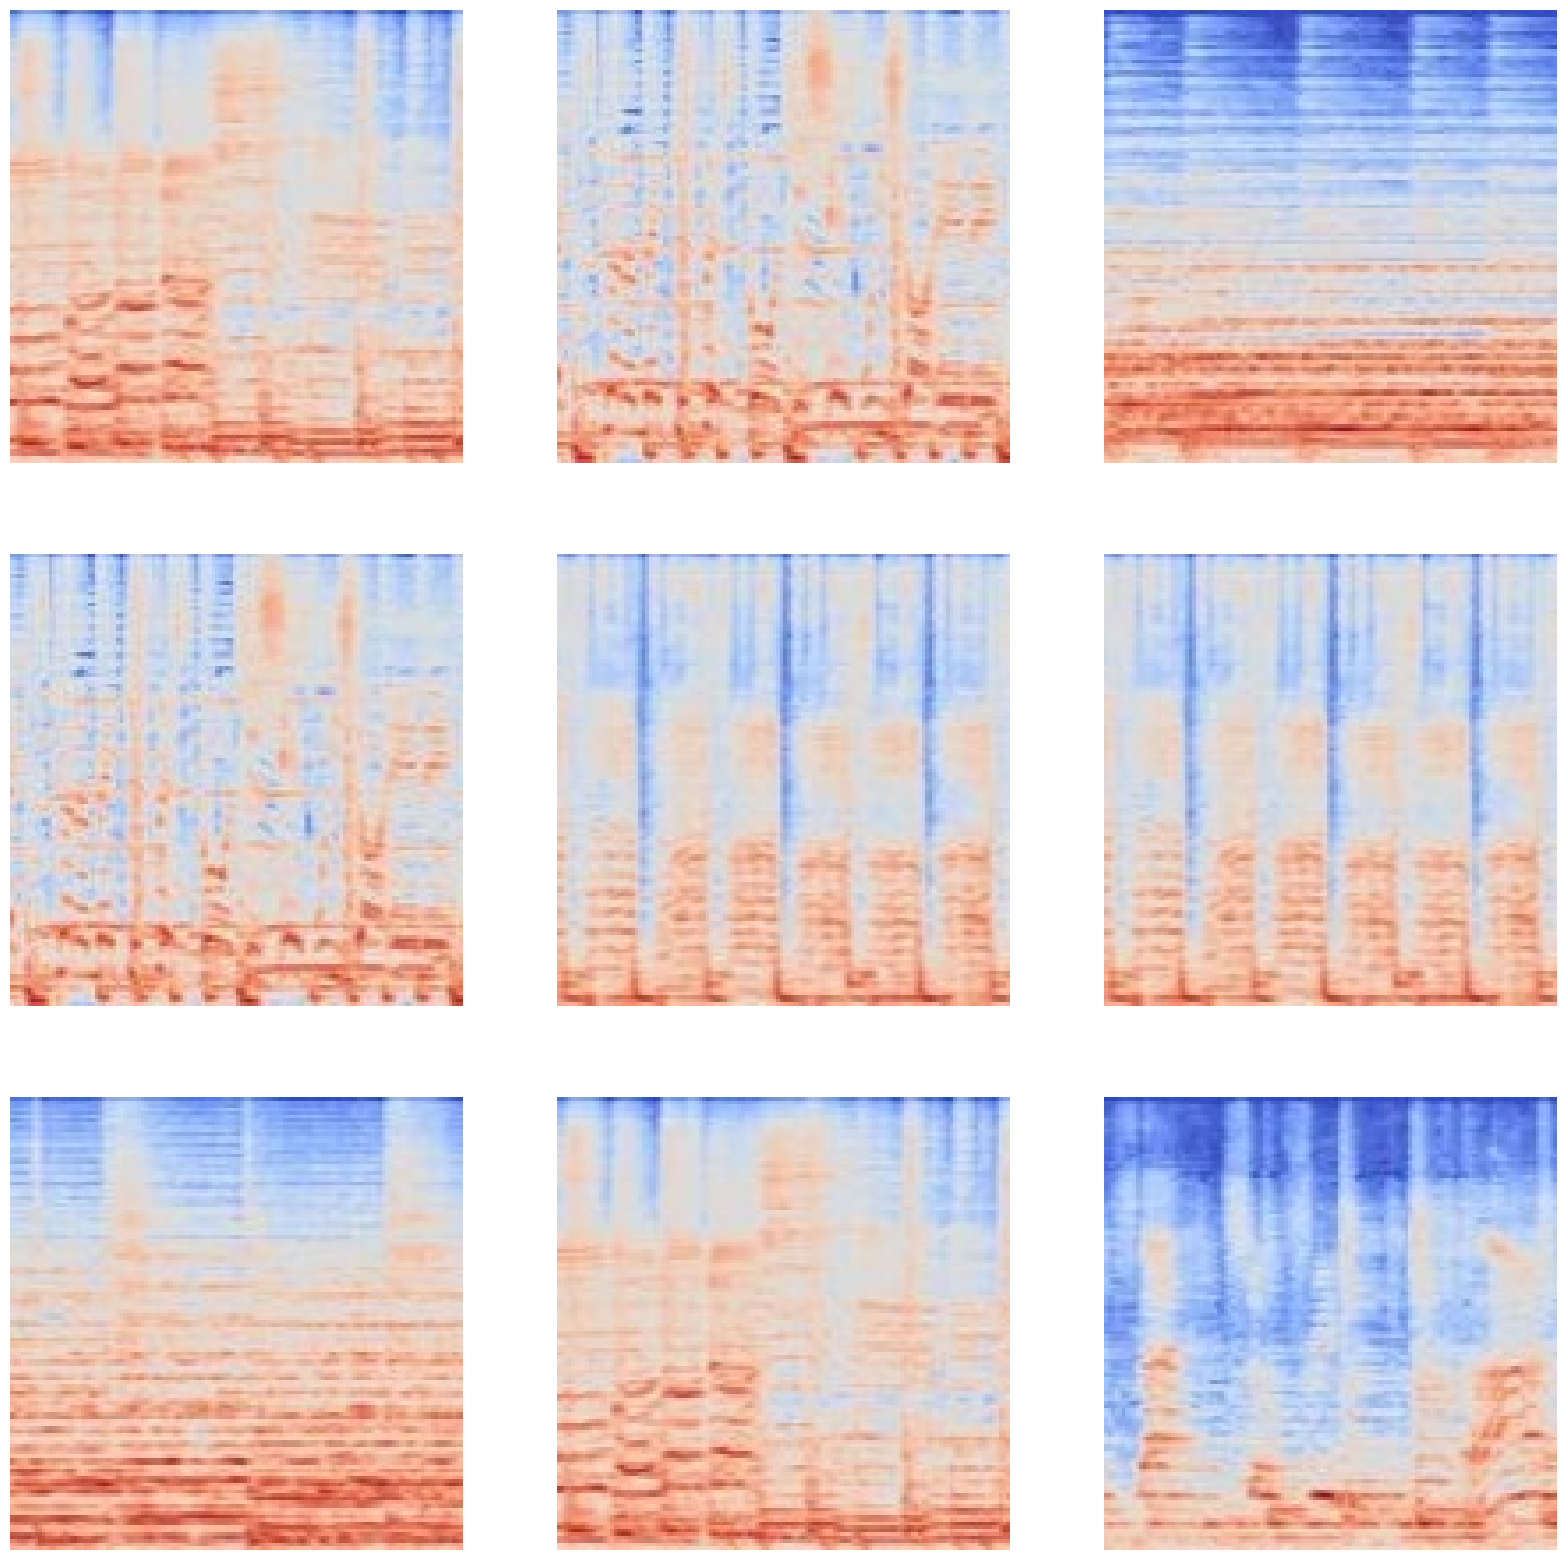

In [ ]:
# plot first 9 items of the training dataset
plt.figure(figsize=(20, 20))
for i in range(9):
  for images in train_ds.take(1):
    for j in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[j].numpy().astype("uint8"), cmap="gray")
        # plt.title(CLASS_NAMES[tf.argmax(labels[i])])
        plt.axis("off")

# 2 Modeltraining

## 2.1 Define Autoencoder

In [ ]:
# define encoder model

def build_encoder(input_shape: Tuple, latent_dim: int = 100):

  encoder_input = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation='relu',
        padding='same')(encoder_input)
  x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation='relu',
        padding='same')(x)
  x = tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation='relu',
        padding='same')(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(latent_dim)(x)
  encoder = tf.keras.Model(inputs=encoder_input, outputs=x, name="encoder")

  return encoder

latent_dim = 100
encoder = build_encoder((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), latent_dim = latent_dim)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 100)               3276900   
                                                                 
Total params: 3370148 (12.86 MB)
Trainable params: 3370148 

In [ ]:
# define decoder model

def build_decoder(latent_dim = latent_dim):
    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(units=16*16*128, activation=tf.nn.relu)(decoder_input)
    x = tf.keras.layers.Reshape(target_shape=(16, 16, 128))(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    # No activation
    decoder_outputs = tf.keras.layers.Conv2DTranspose(
        filters=3, kernel_size=3, strides=1, padding='same')(x)
    decoder = tf.keras.Model(decoder_input, decoder_outputs, name="decoder")

    return decoder

decoder = build_decoder(latent_dim=latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 32)      1846

In [ ]:
# create class autoencoder with encoder and decoder and custom call function

class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoder, decoder)

In [ ]:
# create custom data set generator to have the possibility to return the
#   original image as input und target variable for the CNN
class CustomDatasetIterator:
    def __init__(self, test_ds):
        self.test_ds = test_ds
        self.iterator = iter(self.test_ds)

    def get_next_pair(self):
        try:
            # Get the next element from the test_ds dataset
            next_element = next(self.iterator)

            return next_element, next_element

        except StopIteration:
            # If the iterator reaches the end of the dataset, reset it
            self.iterator = iter(self.test_ds)
            return self.get_next_pair()

    def data_generator(self, batch_size):
        while True:
            batch_x, batch_y = [], []
            for _ in range(batch_size):
                x, y = self.get_next_pair()
                batch_x.append(x[0]/255.)
                batch_y.append(y[0]/255.)
            yield tf.stack(batch_x), tf.stack(batch_y)

In [ ]:
# create custom dataset iterators for train, validation and test dataset
test_ds_custom = CustomDatasetIterator(test_ds)
train_ds_custom = CustomDatasetIterator(train_ds)
val_ds_custom = CustomDatasetIterator(val_ds)

## 2.2 Fit Autoencoder

In [ ]:
# Training parameter
EPOCHS = 50
EARLY_STOPPING_PATIENCE = math.sqrt(EPOCHS)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=2,
                                                  restore_best_weights=True)

In [ ]:
# calculate steps per epoch for training data
steps_per_epoch = len(train_ds) // BATCH_SIZE
steps_per_epoch

3243

In [ ]:
# calculate steps per epoch for validation data (to avoid infinite loop)
validation_steps_per_epoch = len(val_ds) // BATCH_SIZE
validation_steps_per_epoch

718

In [ ]:
# compile and fit the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.fit(train_ds_custom.data_generator(BATCH_SIZE),
                validation_data=val_ds_custom.data_generator(BATCH_SIZE),
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps_per_epoch,
                epochs=EPOCHS, shuffle=True, callbacks=early_stopping)

Epoch 1/50
3243/3243 [==============================] - 426s 129ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 2/50
3243/3243 [==============================] - 394s 122ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/50
3243/3243 [==============================] - 391s 121ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/50
3243/3243 [==============================] - 392s 121ms/step - loss: 0.0037 - val_loss: 0.0068
Epoch 5/50
3243/3243 [==============================] - 392s 121ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 6/50
3243/3243 [==============================] - 407s 126ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/50
3243/3243 [==============================] - 407s 126ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/50
3243/3243 [==============================] - 392s 121ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 9/50
3243/3243 [==============================] - 402s 124ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 10/50
 394/3243 [==>....................

## 2.3 Generating images

In [ ]:
# create a list of ten images to test the encoder
images = []
for item in test_ds.take(10):
    # print(item.shape)
    images.append(item[0]/255.)
images = np.array(images)
images.shape

In [ ]:
# encode the test images
encoded = autoencoder.encoder.predict(images)
encoded.shape

In [ ]:
# decode the encoded test images
decoded = autoencoder.decoder.predict(encoded)
decoded.shape

In [ ]:
# plot first 10 occurences of the dataset
n = 10
plt.figure(figsize=(5, 25))
for i in range(n):
    # display original
    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 2, 2*i+2)
    plt.imshow(decoded[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# create dir to store the model
! mkdir /content/drive/MyDrive/ASSModelh5/

In [ ]:
# save the encoder to google drive
autoencoder.encoder.save("/content/drive/MyDrive/ASSModelh5/AEv3encoder3seconds20epochs", save_format="h5")
autoencoder.encoder.save("/content/drive/MyDrive/ASSModel/AEv3encoder3seconds20epochs")

In [ ]:
# save the decoder to google drive
autoencoder.decoder.save("/content/drive/MyDrive/ASSModelh5/AEv3decoder3seconds20epochs", save_format="h5")
autoencoder.decoder.save("/content/drive/MyDrive/ASSModel/AEv3decoder3seconds20epochs")